In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/colab_final_project/

Mounted at /content/drive


In [3]:
!pip install tensorflow==2.13.0
!pip install protobuf==3.20.3
!pip install nltk==3.7
!pip install numpy==1.23.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [19]:
!pip install langdetect==1.0.9
!pip install pymongo
!pip install emoji
!pip install mysql-connector-python==8.0.33
!pip install scikeras

In [2]:
!pip show tensorflow
!pip show numpy
!pip show nltk

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl
Name: numpy
Version: 1.23.3
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, altair, arviz, astropy, autograd, blis, bokeh, chex, cmdstanpy, contourpy, cufflinks, cvxpy, datascience, db-dtypes, dopamine-rl, ecos, flax, folium, gensi

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import os.path
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import numpy as np
import re
import math
import pandas as pd
import csv
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from langdetect import detect
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pymongo import MongoClient
import emoji
import mysql.connector

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [11]:
emoji_dict = {}
with open('emoji.txt', 'r', encoding='latin-1') as emoji_file:
    for line in emoji_file:
        line = line.strip()
        if line:
            emoji, value = line.split('\t')
            emoji_dict[emoji] = int(value)

In [12]:
def replace_emojis(text, emoji_dict):
    for emoji, value in emoji_dict.items():
        if value == 1:
            text = re.sub(re.escape(emoji), 'happy', text)
        elif value == -1:
            text = re.sub(re.escape(emoji), 'sad', text)
    return text

In [15]:
#vincent
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    words = word_tokenize(text)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    lemmatizer = WordNetLemmatizer()
    tagged = pos_tag(words)
    words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) if get_wordnet_pos(pos) else word for word, pos in tagged]
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

hatefulCorpus=[]
nHatefulCorpus=[]
neutralCorpus=[]
with open("firstIter.csv", "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        if not all(value == "" for value in row.values()):
            text = row["Comment Text"]
            if text == "":
                continue
            label = row["Label"]
            if label == "":
                continue
            try:
                lang=detect(text)
            except:
                lang = ""
            if lang != "en":
                continue
            newText = text.strip()
            newText = replace_emojis(newText, emoji_dict)
            newText = preprocess_text(newText)
            if label=='Neutral':
                neutralCorpus.append(newText)
            elif label=='Hateful':
                hatefulCorpus.append(newText)
            else:
                nHatefulCorpus.append(newText)

## Implementing CNN using Glove Embedding

In [16]:
hatefulCorpus = hatefulCorpus[:272]
print("nutral = "+str(len(neutralCorpus))+" nhateful = "+str(len(nHatefulCorpus))+" hateful = "+str(len(hatefulCorpus)))

nutral = 269 nhateful = 273 hateful = 272


In [20]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
training_corpus=hatefulCorpus + nHatefulCorpus + neutralCorpus

embeddings_index = {}

#Download Glove from http://nlp.stanford.edu/data/glove.6B.zip
with open('embedding_models/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(training_corpus)
word_index = tokenizer.word_index

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(training_corpus)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = np.array([0] * len(hatefulCorpus) + [1] * len(nHatefulCorpus) + [2] * len(neutralCorpus))
y = to_categorical(y, num_classes=3)
size = len(word_index)
embedding_matrix = np.zeros((size + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(optimizer='adam', filters=32, kernel_size=3, dropout_rate=0.5):
    model = Sequential()
    model.add(Embedding(size + 1, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters*2, kernel_size, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(filters*2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#model = KerasClassifier(build_fn=create_model, verbose=0)

#param_grid = {
#    'optimizer': ['adam', 'rmsprop'],
#    'filters': [16, 32, 64, 128],
#    'kernel_size': [3, 5],
#    'dropout_rate': [0.3, 0.5]
#}

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

#grid_result = grid.fit(X_train, y_train)

#print("Best Parameters: ", grid_result.best_params_)
#print("Best Score: ", grid_result.best_score_)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model = create_model(optimizer='adam', filters=32, kernel_size=3, dropout_rate=0.3)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, callbacks=[early_stopping])
model.save('savedModels/CNN_Model')

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
report = classification_report(y_true, y_pred_classes)
print(report)

Epoch 1/40
21/21 [==============================] - 3s 44ms/step - loss: 1.1298 - accuracy: 0.3364 - val_loss: 1.0870 - val_accuracy: 0.4294
Epoch 2/40
21/21 [==============================] - 0s 23ms/step - loss: 1.0803 - accuracy: 0.4055 - val_loss: 1.0794 - val_accuracy: 0.4417
Epoch 3/40
21/21 [==============================] - 0s 22ms/step - loss: 1.0757 - accuracy: 0.4055 - val_loss: 1.0796 - val_accuracy: 0.4724
Epoch 4/40
21/21 [==============================] - 0s 23ms/step - loss: 1.0612 - accuracy: 0.4224 - val_loss: 1.0705 - val_accuracy: 0.4294
Epoch 5/40
21/21 [==============================] - 0s 18ms/step - loss: 1.0608 - accuracy: 0.4485 - val_loss: 1.0632 - val_accuracy: 0.4049
Epoch 6/40
21/21 [==============================] - 0s 16ms/step - loss: 1.0270 - accuracy: 0.4992 - val_loss: 1.0502 - val_accuracy: 0.4110
Epoch 7/40
21/21 [==============================] - 0s 16ms/step - loss: 1.0263 - accuracy: 0.4670 - val_loss: 1.0428 - val_accuracy: 0.4172
Epoch 8/40
21

In [21]:
import random

num_texts = 50  # Number of texts to fetch
testCorpus = []

with open("firstIter.csv", "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    texts = [row["Comment Text"] for row in reader if row["Comment Text"]]
    random.shuffle(texts)
    for text in texts:
        try:
            lang = detect(text)
        except:
            lang = ""
        if lang == "en":
            newText = text.strip()
            newText = replace_emojis(newText, emoji_dict)
            newText = preprocess_text(newText)
            testCorpus.append(newText)
            if len(testCorpus) == num_texts:
                break

In [22]:
# Converting to wordEmbeddings
# Load the tokenizer from the saved file
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
input_sequences = tokenizer.texts_to_sequences(testCorpus)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## MySQL Operations

In [ ]:
def embeddings_dict(testCorpus, padded_sequences, dim=100):
    for i in range(len(padded_sequences)):
        yield (str(testCorpus[i]), padded_sequences[i])

In [ ]:
import io
def adapt_array(array):
    out = io.BytesIO()
    np.save(out, array)
    out.seek(0)
    return out.read()

def convert_array(blob):
    out = io.BytesIO(blob)
    out.seek(0)

    return np.load(out)

In [ ]:
connection = mysql.connector.connect(
    user='root',
    password='bbqsauce',
    host='localhost',
    port=3306,
    database='CNNTest'
)

cursor = connection.cursor()
cursor.execute('CREATE TABLE IF NOT EXISTS `word_embeddings` (`id` INT NOT NULL PRIMARY KEY AUTO_INCREMENT, `hash` INT NOT NULL, `sentence` TEXT, `embedding` BLOB, `timestamp` DATETIME);')
connection.commit()

### Inserting into database

In [ ]:
from datetime import datetime
import random
uniqueId=random.randint(10000, 99999)
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for key, emb in embeddings_dict(testCorpus, padded_sequences, 100):
    arr = adapt_array(emb)
    cursor.execute('INSERT INTO `word_embeddings` (`hash`, `sentence`, `embedding`, `timestamp`) VALUES (%s, %s, %s, %s);', (uniqueId, key, arr, timestamp))
    connection.commit()

### Retrieving from DB

In [ ]:
cursor.execute('SELECT `sentence`, `embedding` FROM `word_embeddings` WHERE `hash` = %s;', (uniqueId,))
results = cursor.fetchall()
embeddings_dict = {}
padded_sequences = []

for row in results:
    sentence = row[0]
    blob_data = row[1]
    embedding = convert_array(blob_data)

    embeddings_dict[sentence] = embedding
    padded_sequences.append(embedding)

padded_sequences = np.array(padded_sequences)

50
2/2 [==============================] - 0s 11ms/step
{'Hateful': 17, 'Non-Hateful': 17, 'Neutral': 16}


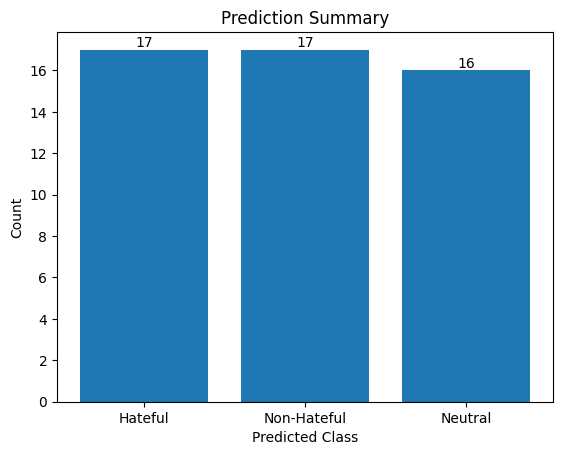

In [23]:
MAX_SEQUENCE_LENGTH = 100
class_labels = ['Hateful', 'Non-Hateful', 'Neutral']
print(len(testCorpus))

# Load the model
loaded_model = tf.keras.models.load_model('savedModels/CNN_Model')

# Make predictions on the padded sequences
predictions = loaded_model.predict(padded_sequences)
predicted_classes = np.argmax(predictions, axis=1)

# Count the predictions for each class
prediction_summary = {label: 0 for label in class_labels}
for predicted_class in predicted_classes:
    predicted_label = class_labels[predicted_class]
    prediction_summary[predicted_label] += 1

print(prediction_summary)
# Prepare data for bar chart
labels = list(prediction_summary.keys())
values = list(prediction_summary.values())

# Plot the bar chart
plt.bar(labels, values)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Prediction Summary')
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()


## Establishing connection with MongoDB

In [ ]:
#Establishing Connection
try:
    client= MongoClient("mongodb://localhost:27017")
    #Get Database
    db=client.get_database('Vector_Data')
    #Get C ollection and preprocessed_data is table name inside db
    collection=db.preprocessed_data
    # initial number of elements
    print('No of elements:{}'.format( collection.count_documents({})))
except:
    print('Connection Failed')

No of elements:755


#### Inserting elements in MongoDB

In [ ]:
from datetime import datetime
import random
uniqueId=random.randint(10000, 99999)
# inserting all elements in preprocessed_data
for row in padded_sequences:
    document = {str(uniqueId):row.tolist()}
    collection.insert_one(document)
# insertion check
collection.count_documents({})

50

#### Retrieving Data from MongoDB

In [ ]:
vector_data = []
uniqueId="eb0fa73b-1474-11ee-af40-c39db335b146"
alldocuments = collection.find({str(uniqueId): {'$exists': True}})
for document in alldocuments:
    vector_data.append(document[str(uniqueId)])
padded_sequences2 = np.array(vector_data)
len(padded_sequences2)

70

3/3 [==============================] - 0s 4ms/step
{'Hateful': 2, 'Non-Hateful': 12, 'Neutral': 56}


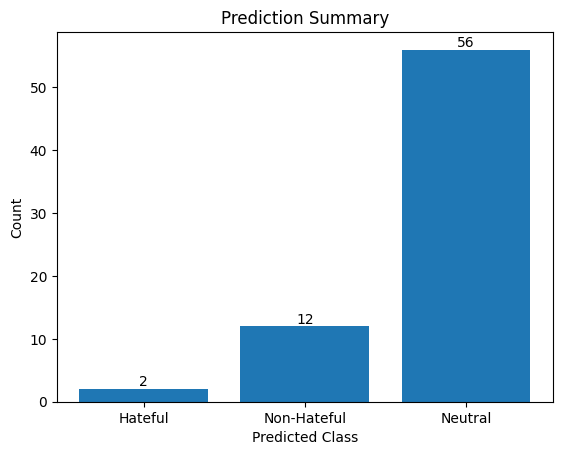

In [ ]:
MAX_SEQUENCE_LENGTH = 100
class_labels = ['Hateful', 'Non-Hateful', 'Neutral']
#print(len(testCorpus))

# Load the model
loaded_model = tf.keras.models.load_model('savedModels/CNN_Model')

# Make predictions on the padded sequences
predictions = loaded_model.predict(padded_sequences2)
predicted_classes = np.argmax(predictions, axis=1)

# Count the predictions for each class
prediction_summary = {label: 0 for label in class_labels}
for predicted_class in predicted_classes:
    predicted_label = class_labels[predicted_class]
    prediction_summary[predicted_label] += 1

print(prediction_summary)
# Prepare data for bar chart
labels = list(prediction_summary.keys())
values = list(prediction_summary.values())

# Plot the bar chart
plt.bar(labels, values)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Prediction Summary')
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()


In [ ]:
type(padded_sequences)

numpy.ndarray

In [ ]:
type(padded_sequences2)

numpy.ndarray

In [ ]:
padded_sequences= padded_sequences.reshape(padded_sequences.shape[0], padded_sequences.shape[1], 1)

In [ ]:
padded_sequences

array([[[   0],
        [   0],
        [   0],
        ...,
        [  30],
        [ 370],
        [1333]],

       [[   0],
        [   0],
        [   0],
        ...,
        [ 220],
        [ 220],
        [ 220]],

       [[   0],
        [   0],
        [   0],
        ...,
        [1062],
        [ 244],
        [   2]],

       ...,

       [[   0],
        [   0],
        [   0],
        ...,
        [   0],
        [ 157],
        [   2]],

       [[   0],
        [   0],
        [   0],
        ...,
        [ 124],
        [  46],
        [ 763]],

       [[  37],
        [1083],
        [1258],
        ...,
        [ 149],
        [ 215],
        [   1]]])

In [ ]:
import pandas as pd
testCorpus = pd.Series(testCorpus)

In [ ]:
load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')

In [ ]:
loaded_model = tf.keras.models.load_model('savedModels/TransformerSentiment')

FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on JOSEMON_BABY. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
tf.__version__

'2.11.0'